<a href="https://colab.research.google.com/github/KimNikita/machine-learning-practice/blob/main/Anime%20rating%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Постановка задачи

## Задача восстановления регрессии: предсказание ожидаемого конечного пользовательского рейтинга аниме по его характеристикам
## Область применения: упрощение выбора аниме для просмотра из числа вышедших в текущем сезоне года. Проблема состоит в том, что процент действительно "хороших" аниме среди вышедших довольно низок. При этом, чтобы отделить "хорошие" от "плохих", необходимо вручную просмотреть как минимум половину серий, что в худшем случае обернется потерей времени и настроения. А ориентироваться на пользовательский рейтинг первые полгода - бессмысленно ввиду разных причин (конкретика опускается).


# 2. Чтение данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/KimNikita/machine-learning-practice/main/anime-dataset-2023.csv"
data_raw = pd.read_csv(url)

In [ ]:
data_raw.shape

(24905, 24)

In [ ]:
data_raw.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


# 3. Удаление ненужных столбцов

In [3]:
data = data_raw.drop(data_raw.columns[[0, 1, 3, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23]], axis=1)
data.head()

,English name,Score,Genres,Synopsis,Type,Episodes,Premiered,Source,Rating
0,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,spring 1998,Original,R - 17+ (violence & profanity)
1,Cowboy Bebop: The Movie,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,UNKNOWN,Original,R - 17+ (violence & profanity)
2,Trigun,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,spring 1998,Manga,PG-13 - Teens 13 or older
3,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,summer 2002,Original,PG-13 - Teens 13 or older
4,Beet the Vandel Buster,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,fall 2004,Manga,PG - Children


# 4. Удаление ненужных строк (фильтрация)

In [4]:
data = data.loc[data['Score'] != 'UNKNOWN']
data = data.loc[data['Synopsis'] != 'No description available for this anime.']
data = data.loc[data['Episodes'] != '1.0']
data = data.loc[data['Type'].isin(['ONA', 'TV', 'UNKNOWN'])]
data = data.loc[data['Source'].isin(['Original', 'Manga' 'Light novel', '4-koma manga', 'Visual novel', 'Other', 'Novel', 'Game', 'Book', 'Web manga', 'Mixed media', 'Card game', 'Web novel', 'UNKNOWN'])]

## Удаление "плохих" жанров

In [5]:
cid = data.columns.get_loc('Genres')
rows_to_drop=[]
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur.find('Hentai') != -1 or cur.find('Erotica') != -1:
    rows_to_drop.append(i)

data.reset_index(inplace=True)
data.drop(rows_to_drop, inplace=True)
data.drop('index', inplace=True, axis=1)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

## Удаление сиквелов \\ приквелов

In [6]:
def mycmp(name):
  return len(name[0])

names=[]
i=0
for name in data['English name']:
  names.append((name, i))
  i+=1
names = sorted(names, key=mycmp)

rows_to_drop=[]
for index, name in enumerate(names):
  spaces = name[0].count(' ')
  for i in range(index+1, data.shape[0]):
    if names[i][0].count(' ') > spaces and names[i][0].startswith(name[0]):
      rows_to_drop.append(names[i][1])

data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.drop('English name', inplace=True, axis=1)

# 5. Преобразование данных

## Столбец Score

In [7]:
cid = data.columns.get_loc('Score')
for i in range(data.shape[0]):
  cur = round(float(data.iat[i, cid]), 1)
  data.iat[i, cid] = cur

## Столбец Genres

In [8]:
unique_genres={}
cid = data.columns.get_loc('Genres')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  genres = cur.split(', ')
  for genre in genres:
    if genre in unique_genres:
      unique_genres[genre]+=1
    else:
      unique_genres[genre]=0
unique_genres = sorted(unique_genres.items(), key=lambda item: item[1], reverse=True)
print(data.shape)
unique_genres

(2577, 8)


[('Comedy', 957),
 ('Action', 868),
 ('Fantasy', 701),
 ('Adventure', 590),
 ('Sci-Fi', 582),
 ('Drama', 413),
 ('Slice of Life', 321),
 ('Romance', 307),
 ('Supernatural', 199),
 ('Mystery', 183),
 ('UNKNOWN', 129),
 ('Ecchi', 97),
 ('Sports', 83),
 ('Horror', 68),
 ('Suspense', 46),
 ('Award Winning', 32),
 ('Gourmet', 32),
 ('Boys Love', 20),
 ('Girls Love', 15),
 ('Avant Garde', 11)]

In [9]:
usable_genres=[]
for genre in unique_genres:
  if genre[0] != 'UNKNOWN' and float(genre[1]) > data.shape[0]*0.05:
    usable_genres.append(genre[0])
    data.insert(cid+1, 'Genre ' + genre[0], 0)

usable_genres

['Comedy',
 'Action',
 'Fantasy',
 'Adventure',
 'Sci-Fi',
 'Drama',
 'Slice of Life',
 'Romance',
 'Supernatural',
 'Mystery']

In [10]:
rows_to_drop=[]
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  genres = cur.split(', ')
  f=0
  for genre in genres:
    if genre not in usable_genres:
      f=1
      rows_to_drop.append(i)
      break
  if f==0:
    for genre in genres:
      data.iat[i, data.columns.get_loc('Genre ' + genre)]=1

data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.drop('Genres', inplace=True, axis=1)
data.shape

(2062, 17)

## Столбец Synopsis

### Вариант с уже натренированной моделью, отсутствующие в словаре слова игнорируются

In [11]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 58.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=90054abbded05399e94209c728aa32a197b95a1eab71a0ca5f8af5cd3c02ac68
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [12]:
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
import gensim.downloader as api
word2vec = api.load('glove-wiki-gigaword-50')

def normalize(text):
  text = re.sub(r'[^\w\s]+|[\d]+', '', text).strip()
  text = word_tokenize(text.lower(), language="english")
  norm_text=[]
  for token in text:
    if token not in stop_words:
        norm_text.append(morph.parse(token)[0].normal_form)
  return norm_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 66.0/66.0MB downloaded


In [13]:
cid = data.columns.get_loc('Synopsis')
len_tokens = []
min_coef = 100000
max_coef = -100000
for i in range(data.shape[0]):
  cur = normalize(data.iat[i, cid])
  len_tokens.append(len(cur))
  misses = 0
  vectors = []
  for token in cur:
    try:
      vector = word2vec[token]
      if min(vector) < min_coef:
        min_coef = min(vector)
      if max(vector) > max_coef:
        max_coef = max(vector)
      vectors.append(vector)
    except KeyError:
      misses+=1
  data.iat[i, cid] = vectors

In [14]:
print(min(len_tokens))
print(np.mean(len_tokens))
print(max(len_tokens))
print(misses)
data.head()

3
56.72017458777886
204
1


,Score,Genre Mystery,Genre Supernatural,Genre Romance,Genre Slice of Life,Genre Drama,Genre Sci-Fi,Genre Adventure,Genre Fantasy,Genre Action,Genre Comedy,Synopsis,Type,Episodes,Premiered,Source,Rating
0,7.2,1,1,0,0,1,0,0,0,1,0,"[[-0.26362, 0.41994, -0.79729, 0.86664, 0.5893...",TV,26.0,summer 2002,Original,PG-13 - Teens 13 or older
1,7.8,0,0,0,0,1,1,0,0,1,0,"[[0.33243, 0.94777, -0.799, -0.46123, 1.0269, ...",TV,22.0,spring 2003,Original,R+ - Mild Nudity
2,7.0,1,0,0,0,0,0,1,1,0,0,"[[-0.3874, 0.79979, 0.008999, -1.0586, 0.84764...",TV,26.0,spring 2002,Original,PG-13 - Teens 13 or older
3,5.9,0,0,0,0,0,1,1,1,0,0,"[[1.9488, 0.91385, 0.56738, 0.48974, -0.26679,...",TV,13.0,fall 2003,Original,R - 17+ (violence & profanity)
4,6.7,0,0,1,0,1,0,0,0,0,0,"[[0.34417, 0.40189, -0.80101, 0.60554, -0.3647...",TV,26.0,summer 2003,Visual novel,PG-13 - Teens 13 or older


<Axes: ylabel='Count'>

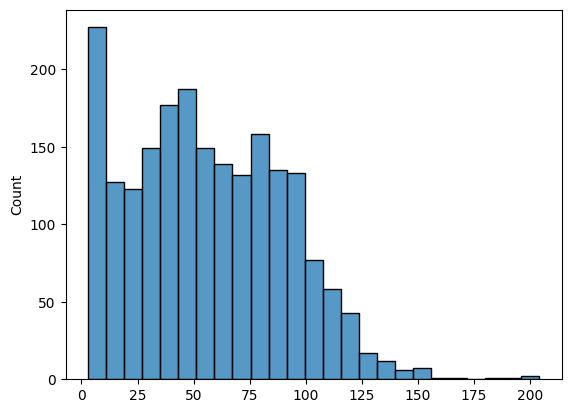

In [16]:
sns.histplot(len_tokens)

In [32]:
token_quants = pd.Series(len_tokens).quantile([0.005, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.995])
token_quants[0.005]

4.0

## Столбец Episodes

In [22]:
cid = data.columns.get_loc('Episodes')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur != 'UNKNOWN':
    cur = float(cur)
    if cur <= 18:
      data.iat[i, cid] = 'half-season'
    elif 18 < cur <= 36:
      data.iat[i, cid] = 'season'
    elif 36 < cur <= 60:
      data.iat[i, cid] = 'double-season'
    elif 60 < cur:
      data.iat[i, cid] = 'no-season'

## Столбец Premiered

In [23]:
cid = data.columns.get_loc('Premiered')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur.startswith('spring'):
    data.iat[i, cid] = 'spring'
  elif cur.startswith('summer'):
    data.iat[i, cid] = 'summer'
  elif cur.startswith('fall'):
    data.iat[i, cid] = 'fall'
  elif cur.startswith('winter'):
    data.iat[i, cid] = 'winter'


# 6. Борьба с выбросами \\ пропущенными значениями (UNKNOWN)

In [24]:
rows_to_drop = data[(data['Score'] < data['Score'].quantile(0.005)) | (data['Score'] > data['Score'].quantile(0.995))].index
data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.shape


(2041, 17)

In [34]:
max_tokens_len = -1
rows_to_drop = []
cid = cid = data.columns.get_loc('Synopsis')
for i in range(data.shape[0]):
  cur = len(data.iat[i, cid])
  if cur < token_quants[0.005] or cur > token_quants[0.995]:
    rows_to_drop.append(i)
  elif cur > max_tokens_len:
    max_tokens_len = cur

data.drop(rows_to_drop, inplace=True)
data.shape

(2003, 17)

In [ ]:
print(data['Type'].value_counts())
print(data['Episodes'].value_counts())
print(data['Premiered'].value_counts())
print(data['Source'].value_counts())
print(data['Rating'].value_counts())

TV     1496
ONA     545
Name: Type, dtype: int64
half-season      1168
season            430
double-season     349
no-season          71
UNKNOWN            23
Name: Episodes, dtype: int64
UNKNOWN    552
spring     484
fall       420
winter     330
summer     255
Name: Premiered, dtype: int64
Original        918
Game            256
Novel           223
Web manga       148
Other           143
4-koma manga    122
Visual novel     97
Mixed media      38
Web novel        35
Book             31
Card game        30
Name: Source, dtype: int64
PG-13 - Teens 13 or older         1280
G - All Ages                       410
PG - Children                      164
R - 17+ (violence & profanity)     137
R+ - Mild Nudity                    35
UNKNOWN                             15
Name: Rating, dtype: int64


In [35]:
data=data.loc[data['Episodes'].isin(['half-season', 'season', 'double-season'])]
data=data.loc[data['Source'].isin(['Original', 'Game', 'Novel', 'Web manga', 'Other', '4-koma manga', 'Visual novel'])]
data=data.loc[data['Rating'].isin(['PG-13 - Teens 13 or older', 'G - All Ages', 'PG - Children', 'R - 17+ (violence & profanity)'])]
data.shape

(1751, 17)

In [ ]:
print(data['Premiered'].value_counts())

UNKNOWN    468
spring     438
fall       354
winter     291
summer     229
Name: Premiered, dtype: int64


# 7. Преобразование типов

In [36]:
data['Score'] = data['Score'].astype('float')
data['Type'] = data['Type'].astype('category')
data['Episodes'] = data['Episodes'].astype('category')
data['Premiered'] = data['Premiered'].astype('category')
data['Source'] = data['Source'].astype('category')
data['Rating'] = data['Rating'].astype('category')

# 8. Визуализация

## В таблице чем правее находится жанр тем чаще он используется

In [ ]:
data.describe()

,Score,Genre Mystery,Genre Supernatural,Genre Romance,Genre Slice of Life,Genre Drama,Genre Sci-Fi,Genre Adventure,Genre Fantasy,Genre Action,Genre Comedy
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,6.547472,0.058989,0.070787,0.130899,0.150562,0.167416,0.253933,0.254494,0.289888,0.375843,0.407865
std,0.750177,0.235670,0.256540,0.337385,0.357722,0.373452,0.435382,0.435699,0.453838,0.484476,0.491576
min,4.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,8.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Большинство рассматриваемых аниме произведены в Японии, имеют длительность менее 18 серий, средний возрастной рейтинг и не имеют текстового источника

In [ ]:
data.describe(include=['category'])

,Type,Episodes,Premiered,Source,Rating
count,1780,1780,1780,1780,1780
unique,2,3,5,7,4
top,TV,half-season,UNKNOWN,Original,PG-13 - Teens 13 or older
freq,1318,1077,468,868,1159


## Как видно из диаграммы, наличие таких жанров как Mystery, Supernatural, Romance, Drama, Adventure и Fantasy повышает шансы на более высокую оценку

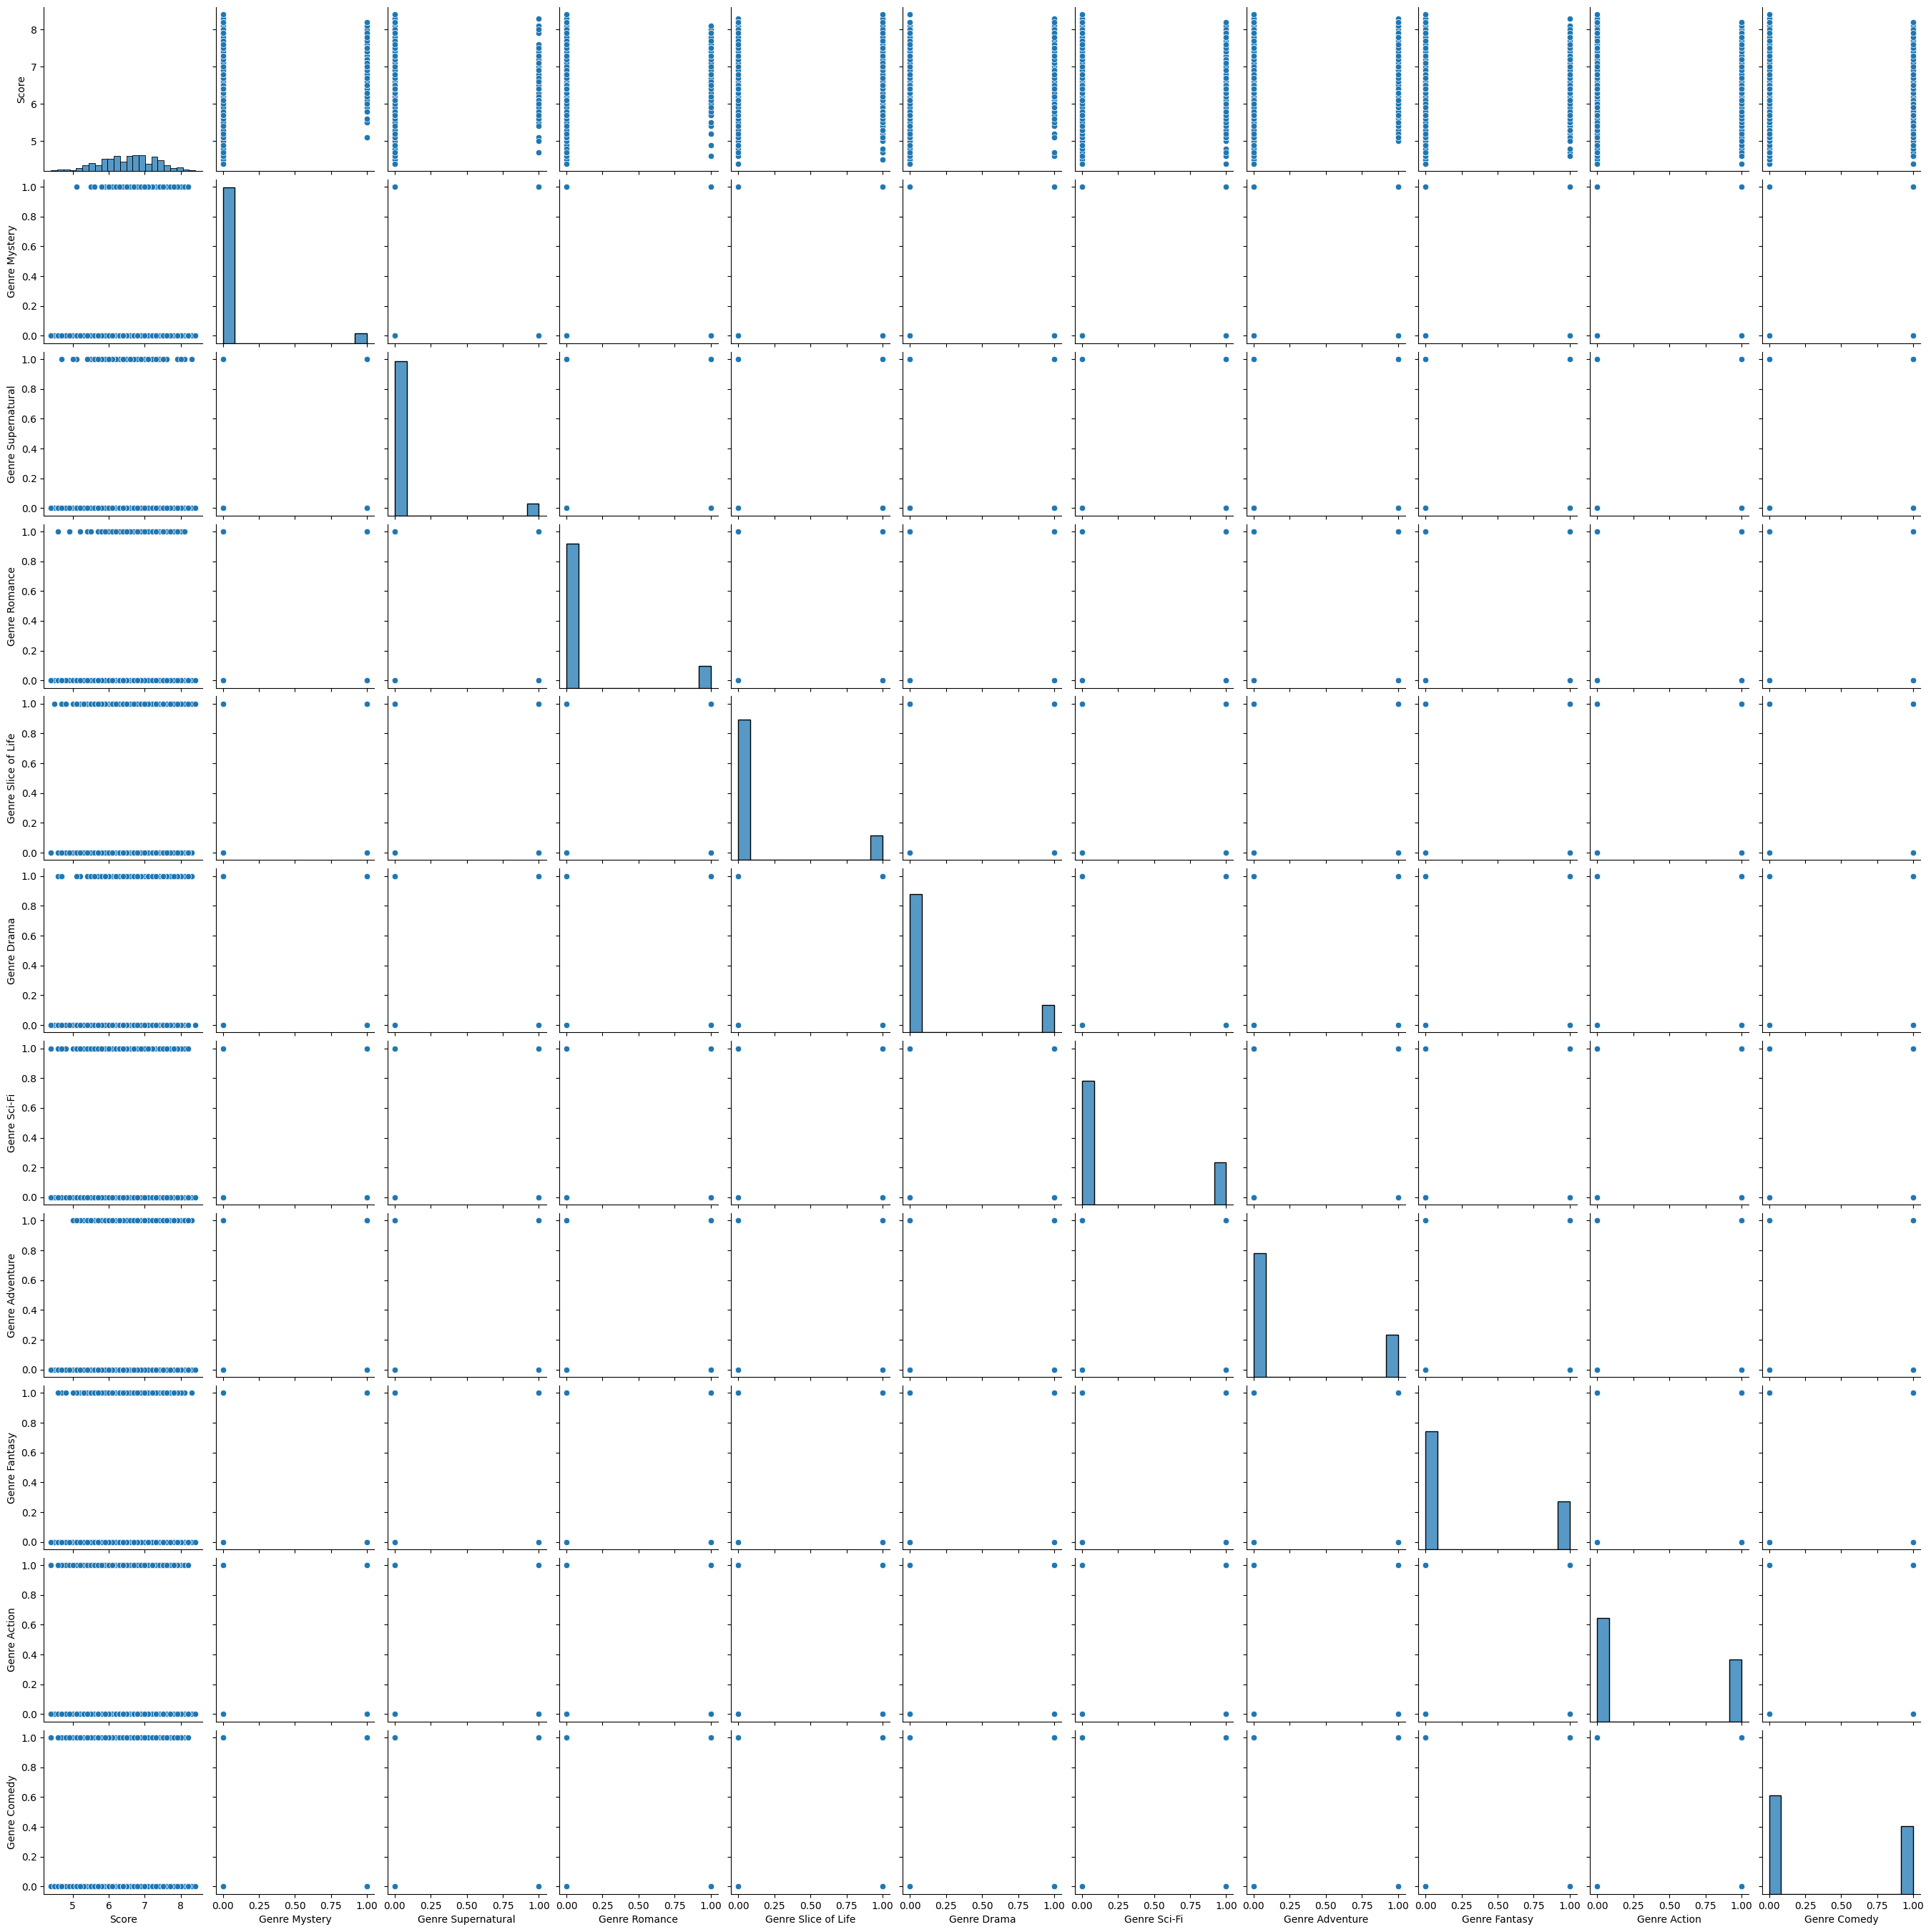

In [ ]:
sns.pairplot(data, diag_kind='hist')
pass

## Аниме, произведенное в Японии, в среднем имеет больший рейтинг

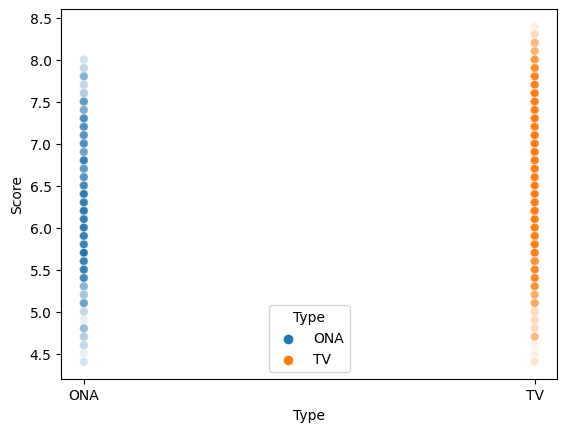

In [ ]:
sns.scatterplot(x='Type', y='Score', hue='Type', data=data, alpha=0.1)
pass

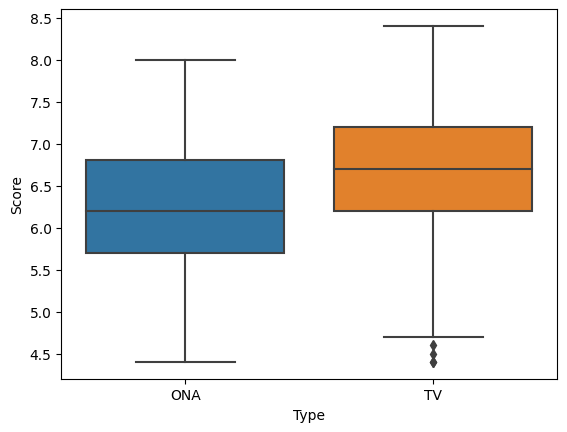

In [ ]:
sns.boxplot(x="Type", y="Score", data=data)
pass

## Аниме с большим количеством эпизодов в основном имеют высокие оценки, что можно объяснить более детальной экранизацией глав текстового источника

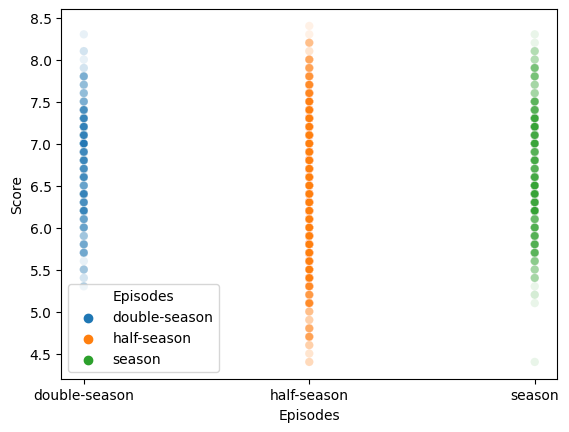

In [ ]:
sns.scatterplot(x='Episodes', y='Score', hue='Episodes', data=data, alpha=0.1)
pass

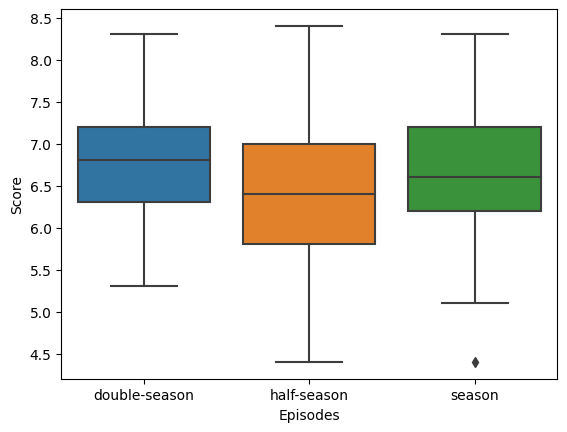

In [ ]:
sns.boxplot(x="Episodes", y="Score", data=data)
pass

## Аниме, выходящие зимой, немного выше оценены

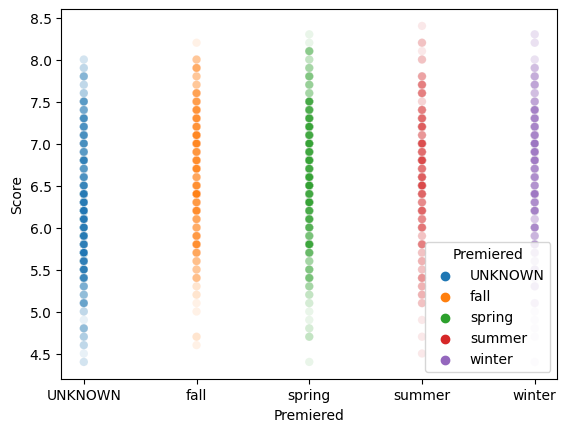

In [ ]:
sns.scatterplot(x='Premiered', y='Score', hue='Premiered', data=data, alpha=0.1)
pass

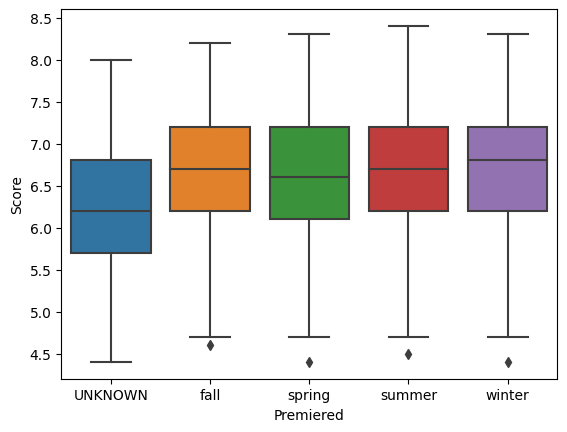

In [ ]:
sns.boxplot(x="Premiered", y="Score", data=data)
pass

## Как видно из диаграммы, аниме, имеющие такие текстовые источники, как 4-koma manga, Novel, Visual novel и Web manga, более высоко оценены

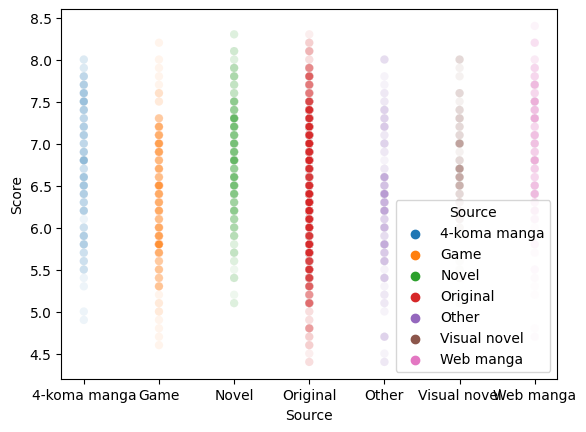

In [ ]:
sns.scatterplot(x='Source', y='Score', hue='Source', data=data, alpha=0.08)
pass

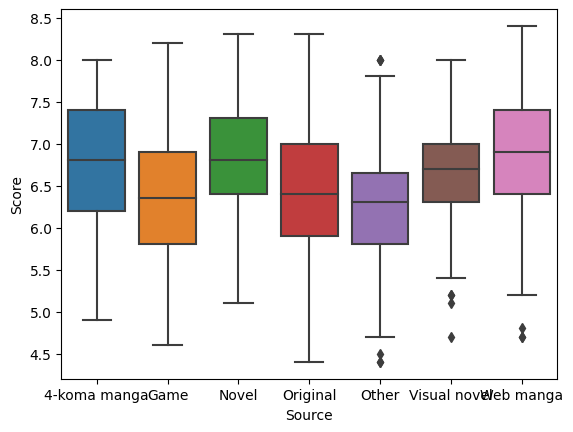

In [ ]:
sns.boxplot(x="Source", y="Score", data=data)
pass

## Чем выше возрастной рейтинг тем выше оценка

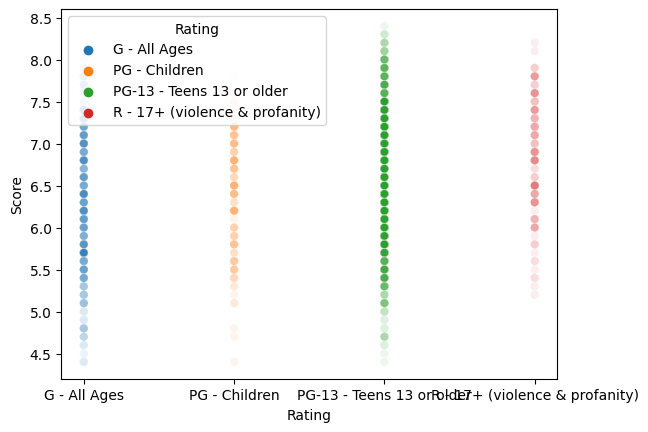

In [ ]:
sns.scatterplot(x='Rating', y='Score', hue='Rating', data=data, alpha=0.08)
pass

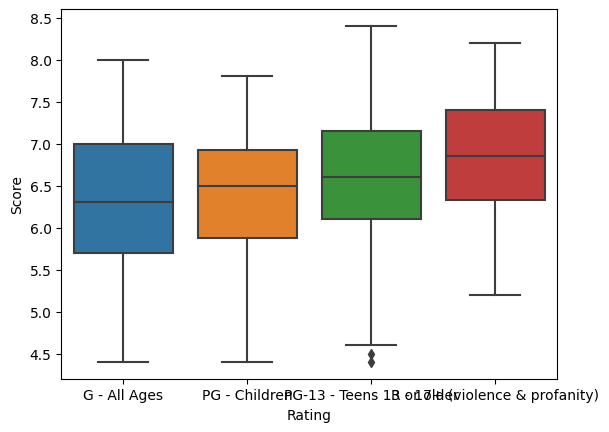

In [ ]:
sns.boxplot(x="Rating", y="Score", data=data)
pass

## Корреляция

In [ ]:
corr_mat = data.corr()
corr_mat

<ipython-input-52-79907eedfcac>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


,Score,Genre Mystery,Genre Supernatural,Genre Romance,Genre Slice of Life,Genre Drama,Genre Sci-Fi,Genre Adventure,Genre Fantasy,Genre Action,Genre Comedy
Score,1.000000,0.081126,0.040654,0.158439,-0.020994,0.217003,0.044820,0.101459,0.050199,0.046154,-0.066863
Genre Mystery,0.081126,1.000000,0.144738,-0.012332,-0.092074,0.092107,0.023760,-0.014901,-0.075881,0.012488,-0.110753
Genre Supernatural,0.040654,0.144738,1.000000,0.029269,-0.042698,0.052252,-0.100631,-0.085827,-0.065303,-0.037792,-0.064146
Genre Romance,0.158439,-0.012332,0.029269,1.000000,-0.116814,0.236416,-0.069518,0.002688,0.031044,-0.101695,-0.037393
Genre Slice of Life,-0.020994,-0.092074,-0.042698,-0.116814,1.000000,-0.058350,-0.180654,-0.202704,-0.192821,-0.297508,0.056555
Genre Drama,0.217003,0.092107,0.052252,0.236416,-0.058350,1.000000,0.021877,-0.013264,-0.087513,-0.080781,-0.203754
Genre Sci-Fi,0.044820,0.023760,-0.100631,-0.069518,-0.180654,0.021877,1.000000,0.127326,-0.216289,0.277467,-0.216298
Genre Adventure,0.101459,-0.014901,-0.085827,0.002688,-0.202704,-0.013264,0.127326,1.000000,0.237883,0.185724,-0.125354
Genre Fantasy,0.050199,-0.075881,-0.065303,0.031044,-0.192821,-0.087513,-0.216289,0.237883,1.000000,0.156115,-0.127135
Genre Action,0.046154,0.012488,-0.037792,-0.101695,-0.297508,-0.080781,0.277467,0.185724,0.156115,1.000000,-0.327751


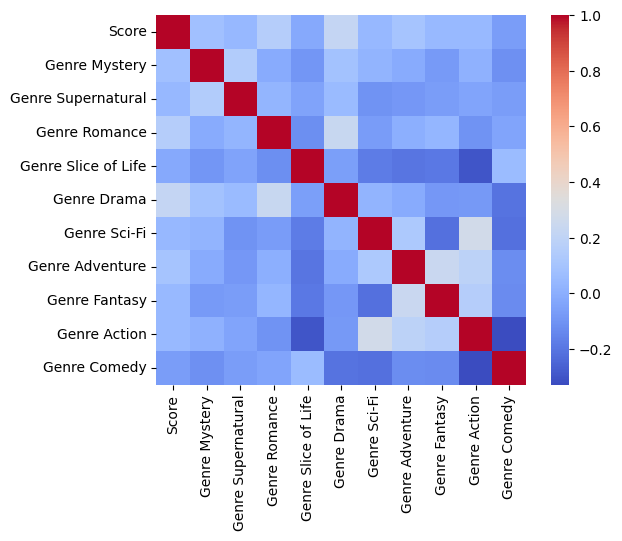

In [ ]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### Так как признаки бинарные и до разбиения были частью составного признака, корреляция в основном показывает как часто 2 жанра встречаются вместе

In [ ]:
corr_mat.where(np.triu(corr_mat > 0.1, k=1)).stack().sort_values(ascending=False)

Genre Sci-Fi     Genre Action          0.277467
Genre Adventure  Genre Fantasy         0.237883
Genre Romance    Genre Drama           0.236416
Score            Genre Drama           0.217003
Genre Adventure  Genre Action          0.185724
Score            Genre Romance         0.158439
Genre Fantasy    Genre Action          0.156115
Genre Mystery    Genre Supernatural    0.144738
Genre Sci-Fi     Genre Adventure       0.127326
Score            Genre Adventure       0.101459
dtype: float64

# 9. Предобработка признаков

## Не учитываем столбец Premiered как особо не влияющий на Score

In [37]:
data = pd.concat((data, pd.get_dummies(data['Type'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Episodes'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Source'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Rating'])), axis=1)

data.drop('Type', inplace=True, axis=1)
data.drop('Episodes', inplace=True, axis=1)
data.drop('Source', inplace=True, axis=1)
data.drop('Rating', inplace=True, axis=1)
data.drop('Premiered', inplace=True, axis=1)
data.shape

(1751, 28)

## Корреляция с учетом бинаризации номинальных признаков

In [ ]:
corr_mat = data.corr()
corr_mat.where(np.triu(corr_mat > 0.25, k=1)).stack().sort_values(ascending=False)

<ipython-input-22-9694c357df55>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


Genre Romance  Visual novel    0.369510
Genre Comedy   4-koma manga    0.287302
Genre Sci-Fi   Genre Action    0.277467
dtype: float64

## Текстовый признак

In [38]:
size = data.shape[1]
for i in range(max_tokens_len):
  for j in range(50):
    data.insert(loc=size+i*50+j, column=f'token_{i}_coef_{j}', value=0)
data.shape

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-38-00ded45542f6>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(loc=size+i*50+j, column=f'token_{i}_coef_{j}', value=0)
<ipython-input-38-00ded45542f6>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(loc=size+i*50+j, column=f'token_{i}_coef_{j}', value=0)
<ipython-input-38-00ded45542f6>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

(1751, 7428)

In [39]:
cid = data.columns.get_loc('Synopsis')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  for k, vector in enumerate(cur):
    for j in range(50):
      data.iat[i, size+k*50+j] = (vector[j] - min_coef) / (max_coef - min_coef)
data.drop('Synopsis', inplace=True, axis=1)

# 10. Machine learning

## Разбиение данных

In [40]:
from sklearn.model_selection import train_test_split

X = data.drop(['Score'], axis=1)
y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(1400, 351)

## Метод ближайших соседей

### Коэффициент R2 получился довольно низким, что указывает на близость модели к константному предсказанию, что не очень хорошо

In [41]:
from sklearn import neighbors
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.17133943431784993

### Из прикладных соображений далее попробуем использовать собственную метрику качества. Если предсказанное значение отличается от истинного не более чем на 0.2, то ошибка = 0. В противном случае считаем сколько раз 0.2 помещается между предсказанным и истинным значениями и нормируем на половину размаха значений Score (4.4 - 8.4)

In [42]:
import math
def my_score(y_predict_test, y_test):
  errors=[]
  y_test = y_test.tolist()
  for i in range(len(y_predict_test)):
    errors.append(min(1, math.floor(abs(y_predict_test[i]-y_test[i])/0.2)/((8.4-4.4)/2/0.2)))
  return 1-np.mean(errors)

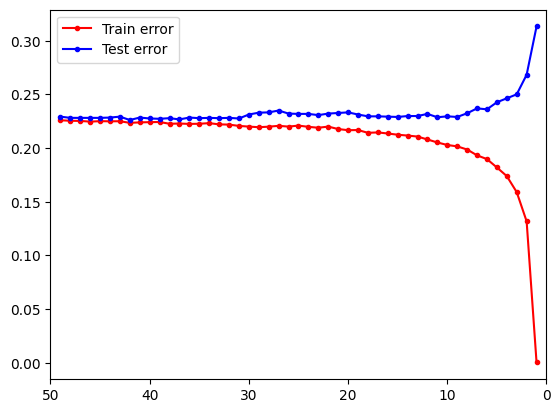

In [43]:
from sklearn import neighbors
kk = range(1, 50)
err_train = []
err_test = []
for k in kk:
    model = neighbors.KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train, y_train)
    err_train.append(1-my_score(model.predict(X_train), y_train))
    err_test.append(1-my_score(model.predict(X_test), y_test))
plt.plot(kk, err_train, '.-r', label = 'Train error')
plt.plot(kk, err_test,  '.-b', label = 'Test error')
plt.legend(loc = 0)
plt.xlim([50, 0])
pass

### Неплохие результаты, стоит отметить, что потребовалось большое кол-во соседей

In [46]:
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 42)
knn_model.fit(X_train, y_train)
my_score(knn_model.predict(X_test), y_test)

0.7737891737891738

## Линейная регрессия (очевидно плохо из-за текстового признака)

In [47]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
my_score(lr_model.predict(X_test), y_test)

0.00512820512820511

## Случайный лес

In [48]:
from sklearn import ensemble
rf_model = ensemble.RandomForestRegressor(n_estimators = 50)
rf_model.fit(X_train, y_train)
my_score(rf_model.predict(X_test), y_test)

0.7732193732193732

## Метод опорных векторов

In [52]:
from sklearn import svm
svm_model = svm.SVR(kernel='rbf')
svm_model.fit(X_train, y_train)
my_score(svm_model.predict(X_test), y_test)

0.7823361823361823

## Сравним метод knn и метод опорных векторов с учетом кросс-валидации (очень долго ~21мин)

In [53]:
X = data.drop(['Score'], axis=1)
y = data['Score']
res_knn=[]
res_svm=[]
for i in range (10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i)
  kk = range(1, 50)
  err=1
  best_k=1
  for k in kk:
      model = neighbors.KNeighborsRegressor(n_neighbors = k)
      model.fit(X_train, y_train)
      if err > 1-my_score(model.predict(X_train), y_train):
        err = 1-my_score(model.predict(X_test), y_test)
        best_k = k
  res_knn.append((1-err, best_k))

  svm_model = svm.SVR(kernel='rbf')
  svm_model.fit(X_train, y_train)
  res_svm.append(my_score(svm_model.predict(X_test), y_test))

### В итоге в среднем точность алгоритма ближайших соседей меньше и она в основном достигается при большом n_neighbors, в то время как более высокая точность при удачном разбиении данных достигается при небольшом n_neighbors

In [54]:
np.mean(res_svm)

0.7874643874643874

In [55]:
knn_score=[]
for res in res_knn:
  knn_score.append(res[0])
print(np.mean(knn_score))
res_knn

0.7685470085470085


[(0.764102564102564, 49),
 (0.762962962962963, 49),
 (0.7495726495726496, 49),
 (0.7706552706552706, 49),
 (0.7666666666666666, 49),
 (0.7823361823361823, 17),
 (0.7737891737891738, 46),
 (0.7777777777777778, 28),
 (0.7769230769230768, 34),
 (0.7606837606837606, 49)]

## К сожалению, точность недостаточно велика, во многом из-за того, что отсутствуют количественные признаки, а текстовый признак, который по идее должен сильнее остальных влиять на оценку, трудно закодировать, сохраняя смысловую нагрузку. К тому же, в рассматриваемых методах трудно учесть комбинацию всех признаков в целом. Задача больше подходит для deep learning

## Ради интереса обучим модели на всей выборке и проверим на данных, не вошедших в выборку

In [ ]:
X = data.drop(['Score'], axis=1)
y = data['Score']

knn_model = neighbors.KNeighborsRegressor(n_neighbors = 49)
knn_model.fit(X, y)

svm_model = svm.SVR(kernel='rbf')
svm_model.fit(X, y)
pass

In [77]:
def get_synopsis(text):
  text = normalize(text)
  synopsis = []
  for i, token in enumerate(text):
    if i > max_tokens_len:
      break
    try:
      vector = word2vec[token]
      synopsis.extend(vector)
    except KeyError:
      continue
  for i in range(len(synopsis)):
    synopsis[i] = (synopsis[i] - min_coef) / (max_coef - min_coef)
  start = 27 + len(synopsis)
  for i in range(start, data.shape[1]):
    synopsis.append(0)
  return synopsis

In [58]:
text = "Barely surviving in a barrel after passing through a terrible whirlpool at sea, carefree Monkey D. Luffy ends up aboard a ship under attack by fearsome pirates. Despite being a naive-looking teenager, he is not to be underestimated. Unmatched in battle, Luffy is a pirate himself who resolutely pursues the coveted One Piece treasure and the King of the Pirates title that comes with it. The late King of the Pirates, Gol D. Roger, stirred up the world before his death by disclosing the whereabouts of his hoard of riches and daring everyone to obtain it. Ever since then, countless powerful pirates have sailed dangerous seas for the prized One Piece only to never return. Although Luffy lacks a crew and a proper ship, he is endowed with a superhuman ability and an unbreakable spirit that make him not only a formidable adversary but also an inspiration to many. As he faces numerous challenges with a big smile on his face, Luffy gathers one-of-a-kind companions to join him in his ambitious endeavor, together embracing perils and wonders on their once-in-a-lifetime adventure."

In [78]:
# One Piece: rating 8.7
synopsis = get_synopsis(text)
coefs = [0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0]
coefs.extend(synopsis)
print(knn_model.predict([coefs]))
print(svm_model.predict([coefs]))

[6.86530612]
[7.04461691]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [79]:
text = "In the entertainment world, celebrities often show exaggerated versions of themselves to the public, concealing their true thoughts and struggles beneath elaborate lies. Fans buy into these fabrications, showering their idols with undying love and support, until something breaks the illusion. Sixteen-year-old rising star Ai Hoshino of pop idol group B Komachi has the world captivated; however, when she announces a hiatus due to health concerns, the news causes many to become worried. As a huge fan of Ai, gynecologist Gorou Amemiya cheers her on from his countryside medical practice, wishing he could meet her in person one day. His wish comes true when Ai shows up at his hospital—not sick, but pregnant with twins! While the doctor promises Ai to safely deliver her children, he wonders if this encounter with the idol will forever change the nature of his relationship with her."

In [81]:
# Oshi no Ko: rating 8.8
synopsis = get_synopsis(text)
coefs = [0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0]
coefs.extend(synopsis)
print(knn_model.predict([coefs]))
print(svm_model.predict([coefs]))

[6.99183673]
[7.11472898]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


## Видно, что точности все еще не хватает :(